#Facial Expression Recognition




Mounted at /content/drive


## Check GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-89688022-9d1d-1a26-4850-096265026ae3)


## Extract and Check Dataset

In [3]:
import tarfile 

file_path = '/content/drive/MyDrive/train_and_val_set.tar'
tar_file = tarfile.open(file_path, 'r')
tar_file.extractall('/content/')


In [21]:
import tarfile 

file_path = '/content/drive/MyDrive/test_set.tar'
tar_file = tarfile.open(file_path, 'r')
tar_file.extractall('/content/')


In [4]:
import os
images = os.listdir('train_set/images')
annots = os.listdir('train_set/annotations')

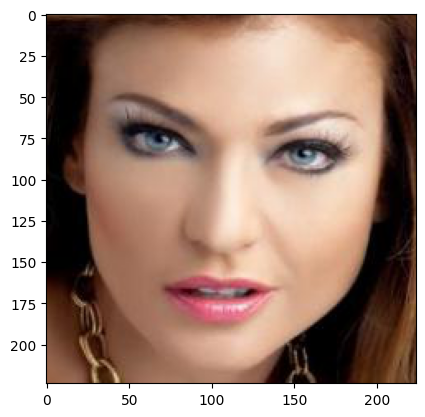

In [5]:
# check random images
import matplotlib.pyplot as plt
import random
import numpy as np

rand_index = random.randint(0, len(images))
img = plt.imread('train_set/images/'+images[rand_index])
plt.imshow(img)

##Lets format the data 

In [6]:
len(images)

287651

In [ ]:
import tensorflow as tf
import numpy as np
import os

# # define the image and annotation directories
image_dir = '/content/train_set/images'
annotation_dir = '/content/train_set/annotations'

# #for test set
# image_dir = '/content/val_set/images'
# annotation_dir = '/content/val_set/annotations'



# create a list of image filenames
image_filenames = os.listdir(image_dir)

# create a dictionary to store the annotations
annotations = {}

# iterate over the image filenames and load the corresponding annotations
for image_filename in image_filenames:
    # extract the image ID from the filename
    image_id = os.path.splitext(image_filename)[0]
    
    # load the expression, arousal, and valence annotations for the image
    exp_filename = os.path.join(annotation_dir, f'{image_id}_exp.npy')
    aro_filename = os.path.join(annotation_dir, f'{image_id}_aro.npy')
    val_filename = os.path.join(annotation_dir, f'{image_id}_val.npy')
    exp = np.load(exp_filename)
    aro = np.load(aro_filename)
    val = np.load(val_filename)
    
    # store the annotations in the dictionary
    annotations[image_id] = (exp, aro, val)
    
# create a list of image paths and their corresponding annotations
image_paths = [os.path.join(image_dir, image_filename) for image_filename in image_filenames]
annotations_list = [annotations[os.path.splitext(image_filename)[0]] for image_filename in image_filenames]

In [23]:
# create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotations_list))

In [24]:
# define a function to preprocess the images and annotations
def preprocess_image(image_path, annotation):
    # load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # preprocess the annotations
    exp = tf.one_hot(int(annotation[0]), depth=8)
    aro = float(annotation[1])
    val = float(annotation[2])
    
    return image, {'category_output': exp, 'aro_out': aro, 'val_out': val}

# apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_image)

# split the dataset into training and validation sets 
train_dataset = dataset.take(200000)
val_dataset = dataset.skip(200000)

#for test set
# test_set = dataset

# define batch size and shuffle buffer size
batch_size = 32
shuffle_buffer_size = 10000

# shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)





# batch the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# for test set
# test_dataset = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [10]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), {'category_output': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'aro_out': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'val_out': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), {'category_output': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'aro_out': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'val_out': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})>)

##Create modelling callbacks

In [11]:
#model check poit callback to save the model's prgress
checkpoint_path = "drive/MyDrive/facial.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_wrights_only=True,
                                                      verbose=0)

##Set up Mixed Percision training

It utilizes the combo of float16 AND float32 to increase the speed


In [12]:
#Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

##Create Feature Extraction Model

In [13]:
#build the model
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessig #if rescaling is needed

#base model
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
#input layer
inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")
#Note: EfficientNetBX has resscaling built in if not 
# x = preprocessing.rescaling(1./255)(x)

x= base_model(inputs, training=False)

x= layers.GlobalAveragePooling2D()(x)
category_out=layers.Dense(8, activation='softmax', name='category_output')(x)
arousal_out=layers.Dense(1, activation='relu', name='aro_out')(x)
valance_out = layers.Dense(1, activation='relu', name='val_out')(x)

outputs= [category_out, arousal_out, valance_out]
model = tf.keras.Model(inputs, outputs)

#compilation
model.compile(optimizer=tf.keras.optimizers.Adam(), loss={'category_output': 'categorical_crossentropy', 'aro_out': 'mse', 'val_out': 'mse'},
              metrics={'category_output': 'accuracy', 'aro_out': 'mae', 'val_out': 'mae'})


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, None, None,   4049571     ['input_layer[0][0]']            
                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetb0[0][0]']         
 alAveragePooling2D)                                                                          

##Fit the model:

In [18]:
history_feature_extraction=model.fit(train_dataset,
          steps_per_epoch=int(0.2*len(train_dataset)), #do not have compute resources
          epochs=5,
          validation_data=val_dataset,\
          validation_steps = int(0.2*len(val_dataset)),
          callbacks=[model_checkpoint])

Epoch 1/5
1250/1250 [==============================] - ETA: 0s - loss: 1.8826 - category_output_loss: 1.4879 - aro_out_loss: 0.1042 - val_out_loss: 0.2905 - category_output_accuracy: 0.4698 - aro_out_mae: 0.2266 - val_out_mae: 0.4636

1250/1250 [==============================] - 458s 338ms/step - loss: 1.8826 - category_output_loss: 1.4879 - aro_out_loss: 0.1042 - val_out_loss: 0.2905 - category_output_accuracy: 0.4698 - aro_out_mae: 0.2266 - val_out_mae: 0.4636 - val_loss: 1.8927 - val_category_output_loss: 1.4861 - val_aro_out_loss: 0.1021 - val_val_out_loss: 0.3045 - val_category_output_accuracy: 0.4710 - val_aro_out_mae: 0.2249 - val_val_out_mae: 0.4693
Epoch 2/5
1250/1250 [==============================] - ETA: 0s - loss: 1.9040 - category_output_loss: 1.4944 - aro_out_loss: 0.1059 - val_out_loss: 0.3037 - category_output_accuracy: 0.4665 - aro_out_mae: 0.2294 - val_out_mae: 0.4683

1250/1250 [==============================] - 486s 389ms/step - loss: 1.9040 - category_output_loss: 1.4944 - aro_out_loss: 0.1059 - val_out_loss: 0.3037 - category_output_accuracy: 0.4665 - aro_out_mae: 0.2294 - val_out_mae: 0.4683 - val_loss: 1.8905 - val_category_output_loss: 1.4838 - val_aro_out_loss: 0.1021 - val_val_out_loss: 0.3045 - val_category_output_accuracy: 0.4710 - val_aro_out_mae: 0.2249 - val_val_out_mae: 0.4693
Epoch 3/5
1250/1250 [==============================] - ETA: 0s - loss: 1.9094 - category_output_loss: 1.5021 - aro_out_loss: 0.1067 - val_out_loss: 0.3006 - category_output_accuracy: 0.4584 - aro_out_mae: 0.2298 - val_out_mae: 0.4646

1250/1250 [==============================] - 350s 273ms/step - loss: 1.9094 - category_output_loss: 1.5021 - aro_out_loss: 0.1067 - val_out_loss: 0.3006 - category_output_accuracy: 0.4584 - aro_out_mae: 0.2298 - val_out_mae: 0.4646 - val_loss: 1.8796 - val_category_output_loss: 1.4730 - val_aro_out_loss: 0.1021 - val_val_out_loss: 0.3045 - val_category_output_accuracy: 0.4710 - val_aro_out_mae: 0.2249 - val_val_out_mae: 0.4693
Epoch 4/5
1249/1250 [============================>.] - ETA: 0s - loss: 1.8994 - category_output_loss: 1.4898 - aro_out_loss: 0.1048 - val_out_loss: 0.3047 - category_output_accuracy: 0.4723 - aro_out_mae: 0.2271 - val_out_mae: 0.4696

1250/1250 [==============================] - 345s 276ms/step - loss: 1.8993 - category_output_loss: 1.4897 - aro_out_loss: 0.1048 - val_out_loss: 0.3047 - category_output_accuracy: 0.4724 - aro_out_mae: 0.2271 - val_out_mae: 0.4697 - val_loss: 1.8832 - val_category_output_loss: 1.4766 - val_aro_out_loss: 0.1021 - val_val_out_loss: 0.3045 - val_category_output_accuracy: 0.4710 - val_aro_out_mae: 0.2249 - val_val_out_mae: 0.4693
Epoch 5/5
1250/1250 [==============================] - ETA: 0s - loss: 1.9003 - category_output_loss: 1.4903 - aro_out_loss: 0.1062 - val_out_loss: 0.3038 - category_output_accuracy: 0.4690 - aro_out_mae: 0.2293 - val_out_mae: 0.4686

1250/1250 [==============================] - 279s 223ms/step - loss: 1.9003 - category_output_loss: 1.4903 - aro_out_loss: 0.1062 - val_out_loss: 0.3038 - category_output_accuracy: 0.4690 - aro_out_mae: 0.2293 - val_out_mae: 0.4686 - val_loss: 1.8883 - val_category_output_loss: 1.4817 - val_aro_out_loss: 0.1021 - val_val_out_loss: 0.3045 - val_category_output_accuracy: 0.4710 - val_aro_out_mae: 0.2249 - val_val_out_mae: 0.4693


In [25]:
len(test_dataset)

125

### Evaluation of EfficientNetB0

In [26]:
results_feature_extract=model.evaluate(test_dataset)

125/125 [==============================] - 6s 44ms/step - loss: 3.2672 - category_output_loss: 2.7438 - aro_out_loss: 0.2693 - val_out_loss: 0.2542 - category_output_accuracy: 0.1250 - aro_out_mae: 0.4402 - val_out_mae: 0.4190


### Prediction with EfficientNetB0

1/1 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'Orignal\tExp 6, Aro 0.624406, Val -0.620085\nPredicted\tExp 6, Aro [[0.1203]], Val [[0.]]')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


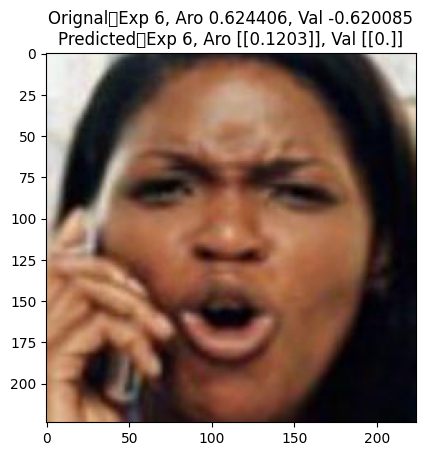

In [37]:
# check random images
import matplotlib.pyplot as plt
import random
import numpy as np

images = os.listdir('/content/val_set/images')
annots = os.listdir('/content/val_set/annotations')

rand_index = random.randint(0, len(images))
exp_filename = images[rand_index].replace('.jpg', '_exp.npy')
aro_filename = images[rand_index].replace('.jpg', '_aro.npy')
val_filename = images[rand_index].replace('.jpg', '_val.npy')
exp = np.load('/content/val_set/annotations/'+exp_filename)
aro = np.load('/content/val_set/annotations/'+aro_filename)
val = np.load('/content/val_set/annotations/'+val_filename)
img = plt.imread('val_set/images/'+images[rand_index])
preds = model.predict(np.expand_dims(img, 0))
plt.imshow(img)
plt.title(f'Orignal\tExp {exp}, Aro {aro}, Val {val}\nPredicted\tExp {np.argmax(preds[0])}, Aro {preds[1]}, Val {preds[2]}')

In [38]:
a=model.predict(np.expand_dims(img, 0))
np.argmax(a[0])

1/1 [==============================] - 0s 28ms/step


6

## With ResNet BaseLine

In [47]:
#build the model
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessig #if rescaling is needed

#base model
input_shape=(224,224,3)
base_model= tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model.trainable=False
#input layer
inputs= tf.keras.layers.Input(shape=input_shape, name="input_layer")
#Note: EfficientNetBX has resscaling built in if not 
# x = preprocessing.rescaling(1./255)(x)

x= base_model(inputs, training=False)

x= layers.GlobalAveragePooling2D()(x)
category_out=layers.Dense(8, activation='softmax', name='exp')(x)
arousal_out=layers.Dense(1, activation='relu', name='aro')(x)
valance_out = layers.Dense(1, activation='relu', name='val')(x)

outputs= [category_out, arousal_out, valance_out]
model = tf.keras.Model(inputs, outputs)

#compilation
model_res.compile(optimizer=tf.keras.optimizers.Adam(), loss={'category_output': 'categorical_crossentropy', 'aro_out': 'mse', 'val_out': 'mse'},
              metrics={'category_output': 'accuracy', 'aro_out': 'mae', 'val_out': 'mae'})

94765736/94765736 [==============================] - 4s 0us/step


In [49]:
history_resnet=model_res.fit(train_dataset,
          steps_per_epoch=int(0.2*len(train_dataset)), 
          epochs=5,
          validation_data=val_dataset,
          validation_steps = int(0.2*len(val_dataset))
          )

Epoch 1/5


ValueError: ignored

### Evaluation of ResNet

In [ ]:
results_feature_extract=model_res.evaluate(test_dataset)

### Making Predictions with ResNet

In [ ]:
# check random images
import matplotlib.pyplot as plt
import random
import numpy as np

images = os.listdir('/content/val_set/images')
annots = os.listdir('/content/val_set/annotations')

rand_index = random.randint(0, len(images))
exp_filename = images[rand_index].replace('.jpg', '_exp.npy')
aro_filename = images[rand_index].replace('.jpg', '_aro.npy')
val_filename = images[rand_index].replace('.jpg', '_val.npy')
exp = np.load('/content/val_set/annotations/'+exp_filename)
aro = np.load('/content/val_set/annotations/'+aro_filename)
val = np.load('/content/val_set/annotations/'+val_filename)
img = plt.imread('val_set/images/'+images[rand_index])
preds = model_res.predict(np.expand_dims(img, 0))
plt.imshow(img)
plt.title(f'Orignal\tExp {exp}, Aro {aro}, Val {val}\nPredicted\tExp {np.argmax(preds[0])}, Aro {preds[1]}, Val {preds[2]}')